In [29]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [30]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 18
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [144]:
# Load data inputs used in optimization model

generators = pd.read_csv("Data/GeneratorsNetwork.csv")
storage_elec = pd.read_csv("Data/Storage_ELECNetwork.csv")
storage_gas = pd.read_csv("Data/Storage_GASNetwork.csv")
p2g = pd.read_csv("Data/PowerToGasNetwork.csv")
appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")

GEN = len(generators)
STORAGE_ELEC = len(storage_elec)
STORAGE_GAS = len(storage_gas)
P2G = len(p2g)

resource_list = np.append(np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()), storage_gas["Prime Mover"].to_numpy())
resource_list = np.where(resource_list == "Net-zero CH4", "Electro-methane",resource_list)

unique_resources = np.append(np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_STORAGE = np.append(storage_elec["Prime Mover"].drop_duplicates().to_numpy(), storage_gas["Prime Mover"].drop_duplicates().to_numpy())
unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)

locational_resources = np.append(np.append(np.append(generators["Node_ELEC"].to_numpy(), storage_elec["Node_ELEC"].to_numpy()), p2g["Node_ELEC"].to_numpy()), storage_gas["Node_ELEC"].to_numpy())

colors = np.array(["black","dimgray","darkgray","gainsboro","yellowgreen","khaki","yellow","gold","darkturquoise","sienna","darkred","deepskyblue","teal",
    "lightcoral","lemonchiffon","darkgreen","limegreen","forestgreen","rosybrown"])

colors_GEN = np.array(["black","dimgray","darkgray","gainsboro","yellowgreen","khaki","yellow","gold","darkturquoise","sienna","darkred","deepskyblue","teal"])
colors_STORAGE = np.array(["lightcoral","lemonchiffon","rosybrown"])
colors_P2G = np.array(["darkgreen","limegreen","forestgreen"])

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
appliances_gascons = pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv")
appliances_eleccons = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
unique_appliancetypes =  appliances["Appliance Name"].drop_duplicates().to_numpy()
appliances_list = appliances["Appliance Name"].to_numpy()


In [160]:
print(len(colors))
print(len(unique_resources))
print(unique_resources_GEN)
print(unique_resources_P2G)
print(unique_resources_STORAGE)

caseNum = 1
date_stamps = ["20230123-151122"]
case_studies = ["Base Case"]
case_names = ["Base Case"]

# 1 = base case, 2 = 0% h2, 3 = 10% h2, 4 = 30% h2
# 5 = no gas appliance by 2045, 6 = no new gas sales 2025 onwards, 7 = no nuclear sub opt termination
# 8 = no forced retirement, 9 = high learning rate for HP SH

# date_stamps = ["20221202-213802","20221202-212330","20221202-215152","20221202-220938",
#     "20221203-004108","20221202-235906","20221202-225733","20221203-153209", "20221205-102533"]
# case_studies = ["Base Case", "00H2", "10H2", "30H2", "No Gas", "No Sales", "No Nuclear","Natural Retire", "HP Cost Decline"]
# case_names = ["Base Case", "0% H2", "10% H2", "30% H2", "No Gas Appliances by 2045", "No Gas Appliances Sales from 2025", "No Nuclear", "Natural Retirement", "Fast Learning Rate of HP"]

19
19
['Coal' 'Natural Gas CC' 'Natural Gas CT' 'Natural Gas CC-CCS' 'Biopower'
 'Solar Thermal' 'Solar PV' 'Res Solar PV' 'Wind' 'Geothermal' 'Nuclear'
 'Hydropower' 'OffshoreWind']
['Biomethane' 'Electrolysis' 'Electro-methane']
['Li-ion battery' 'Long-duration storage']


In [161]:
case1 = case_names[caseNum-1]
date_stamp1 = date_stamps[caseNum-1]
case_study = case_studies[caseNum-1]

folder1 = "Output/%s" % date_stamp1

system = "Network"
region = "Cold"
num = ""

biomethane = "Mid"
industrials = "No"
buildingretrofits = "Low"
GasQuality = "Nodal" # "Annual", "No"

case = "WithAppDecisions"
offsets_case = "LowOffsets"
retirements_case = "NoGasDistRet"

CleanElecCosts = "Mid"
CleanGasCosts = "Mid"
NETSCost = "Mid"

T_inv = 5
Years = np.array([2025,2030,2035,2040,2045])


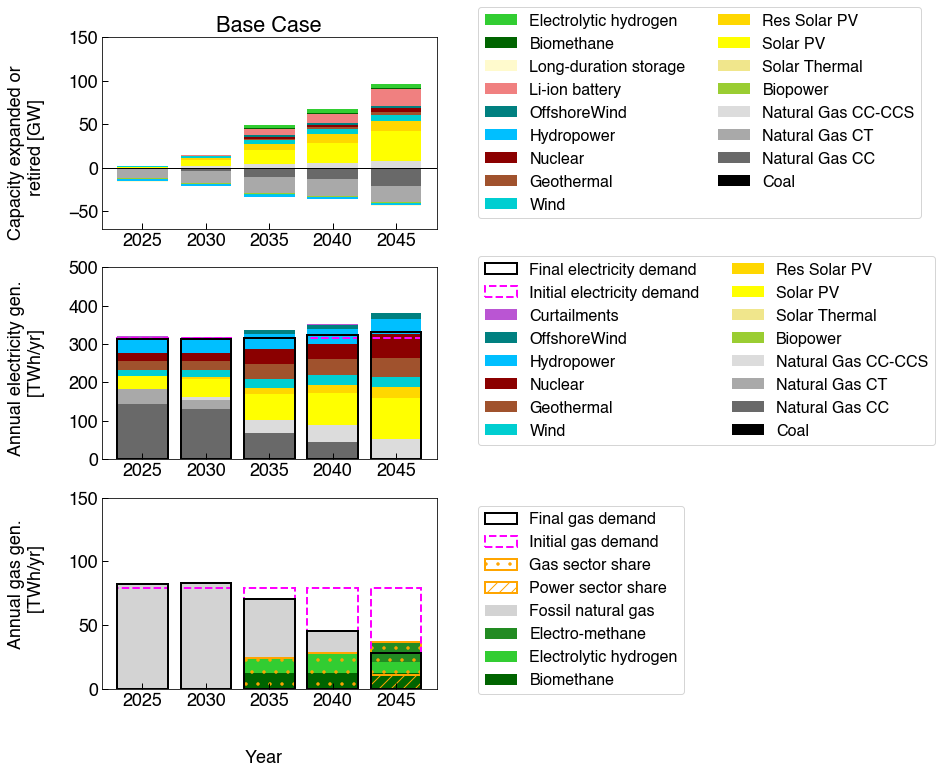

In [162]:
################################################################################################
## Appliance Optimization Scenario Comparisons
################################################################################################
xy = 0
fig, axes = plt.subplots(3, 1, figsize = (6,12))
appliance_cases = np.array([case1])

for i in range(len(appliance_cases)):
    folder = folder1

    # Total capacity built and retired
    resources = np.zeros((len(unique_resources),T_inv))
    resources_minus = np.zeros((len(unique_resources),T_inv))
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityCapacityBuildResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data_retired = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityCapacityRetiredResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    data_retired = data_retired[0:-1,:]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for k in range(len(unique_resources)):
        for j in range(T_inv):
            for jj in range(j+1):
                resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[resource_list == unique_resources[k],jj],0)
                resources[k,j] = resources[k,j]+np.sum(data[resource_list == unique_resources[k],jj],0)

        if sum(resources[k,:]) > 0:
            axes[0].bar(Years, resources[k,:]/10**3, label = unique_resources[k], bottom = stack, width = 4, align = "center", color = colors[k])
            stack = stack + resources[k,:]/10**3
        if sum(resources_minus[k,:]) > 0:
            if sum(resources[k,:]) > 0:
                axes[0].bar(Years, -1*resources_minus[k,:]/10**3, bottom = stack_minus, width = 4, align = "center", color = colors[k])
            if sum(resources[k,:]) <= 0:
                axes[0].bar(Years, -1*resources_minus[k,:]/10**3, label = unique_resources[k], bottom = stack_minus, width = 4, align = "center", color = colors[k])
            stack_minus = stack_minus - resources_minus[k,:]/10**3

    ## Total annual electricity generation
    resource_list_GEN = (generators["Prime Mover"].to_numpy())
    unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
    resource_list_P2G = (p2g["Prime Mover"].to_numpy())
    resource_list_P2G = np.where(resource_list_P2G == "Net-zero CH4", "Electro-methane",resource_list_P2G)
    unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
    unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
    
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityGenerationResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()

    data_elec = data[GEN+P2G:GEN+P2G+8,:].copy()
    data = data[0:GEN,:].copy()
    stack = np.zeros((T_inv))
    for k in range(len(unique_resources_GEN)):
        resources = np.sum(data[resource_list_GEN == unique_resources_GEN[k],:],0)
        axes[1].bar(Years, resources/10**6, label = unique_resources_GEN[k],color = colors_GEN[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources/10**6
    resources = data_elec[7,:].copy()
    axes[1].bar(Years, resources/10**6, label = "Curtailments", color = "mediumorchid", linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")

    resources = np.ones([1,5]) * data_elec[4,0].copy()
    stack = np.zeros((T_inv))
    axes[1].bar(Years, resources[0]/10**6, label = "Initial electricity demand", color = "none", alpha = 1, edgecolor = 'magenta', linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
    resources = data_elec[5,:].copy()
    stack = np.zeros((T_inv))
    axes[1].bar(Years, resources/10**6, label = "Final electricity demand", color = "none", alpha = 1, edgecolor = 'k', linewidth = 2, bottom = stack, width = 4, align = "center")

    ## Total annual gas generation
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityGenerationResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    data_gas = data[GEN+P2G:GEN+P2G+7,:]
    data = data[GEN:GEN+P2G,:]
    stack = np.zeros((T_inv))
    for k in range(len(unique_resources_P2G)):
        resources = np.sum(data[resource_list_P2G == unique_resources_P2G[k],:],0)
        axes[2].bar(Years, resources/10**6, label = unique_resources_P2G[k],color = colors_P2G[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources/10**6
        
    axes[2].bar(Years, np.maximum(data_gas[1,:].copy()/10**6 - stack,0), label = "Fossil natural gas", color = "lightgrey", bottom = stack, width = 4, align = "center")

    resources = data_gas[2,:].copy()
    stack = np.zeros((T_inv))
    axes[2].bar(Years, resources/10**6, label = "Power sector share", color = "none", alpha = 1, edgecolor = 'orange', hatch='//', linewidth = 2, bottom = stack, width = 4, align = "center")
    resources = data_gas[3,:].copy()
    axes[2].bar(Years, resources/10**6, label = "Gas sector share", color = "none", alpha = 1, edgecolor = 'orange', hatch='.', linewidth = 2, bottom = data_gas[2,:]/10**6, width = 4, align = "center")
    resources = np.ones([1,5]) * data_gas[0,0].copy()
    axes[2].bar(Years, resources[0]/10**6, label = "Initial gas demand", color = "none", alpha = 1, edgecolor = 'magenta', linewidth = 2, ls = "--", bottom = stack, width = 4, align = "center")
    resources = data_gas[1,:].copy()
    axes[2].bar(Years, resources/10**6, label = "Final gas demand", color = "none", alpha = 1, edgecolor = 'k', linewidth = 2, bottom = stack, width = 4, align = "center")

    for ii in range(3):
        axes[ii].axhline(linewidth=1, color='k')
        axes[ii].tick_params(direction='in', length=6, width=1, colors='k')

handles, labels = axes[0].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.2), loc='upper left', prop={'size': 16},ncol=2)
handles, labels = axes[1].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.1), loc='upper left', prop={'size': 16},ncol=2)
handles, labels = axes[2].get_legend_handles_labels()
labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
axes[2].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1), loc='upper left',prop={'size': 16})

fig.text(-0.05, 0.75, 'Capacity expanded or \n retired [GW]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.5, 'Annual electricity gen. \n [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(-0.05, 0.25, 'Annual gas gen. \n [TWh/yr]', ha='center', va='center', rotation='vertical')

axes[0].set_ylim([-70,150])
axes[1].set_ylim([0,500])
axes[2].set_ylim([0,150])
axes[0].set_title(case1)

fig.text(0.5, 0.04, 'Year', ha='center')
# fig.suptitle(f"Appliance optimization scenarios")
# fig.savefig(f"Plots/{case_study}/Investment_Period_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()


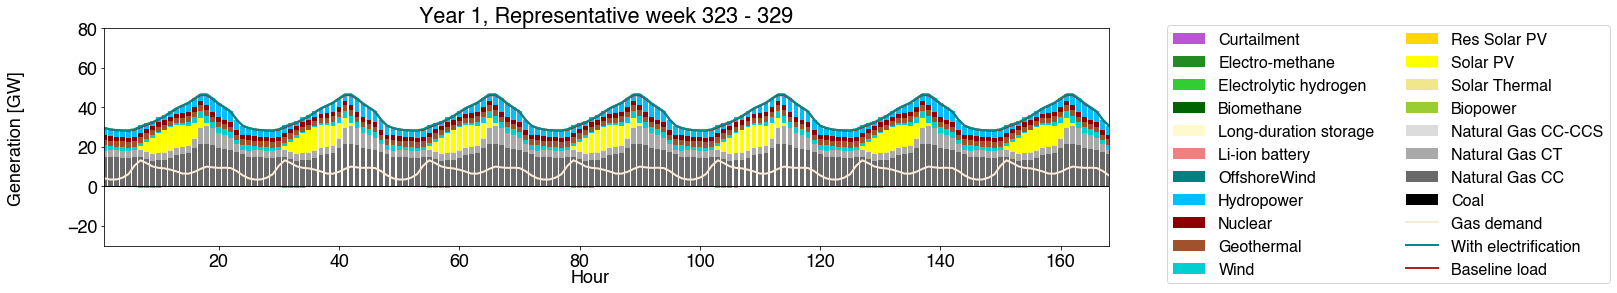

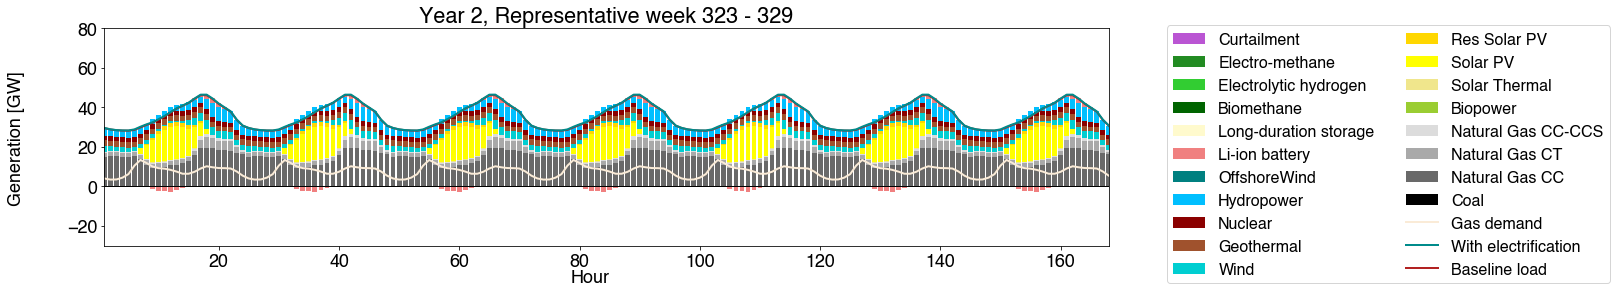

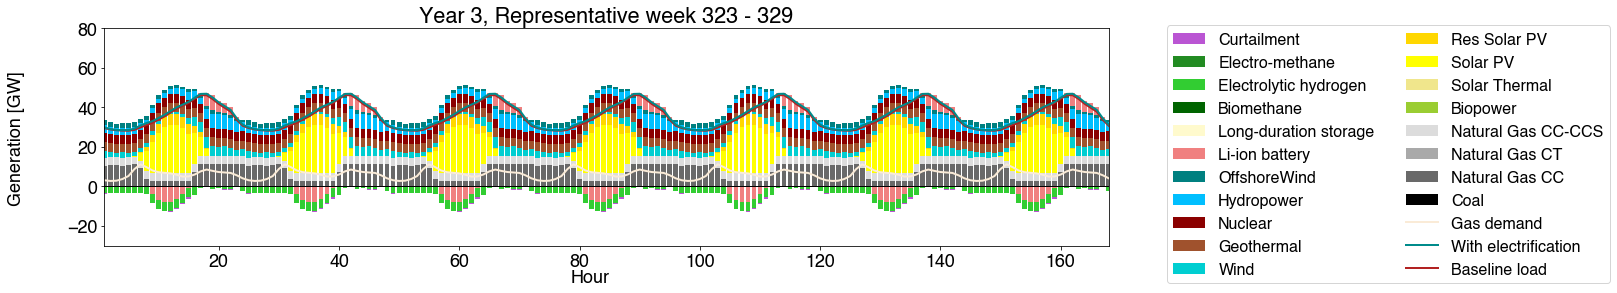

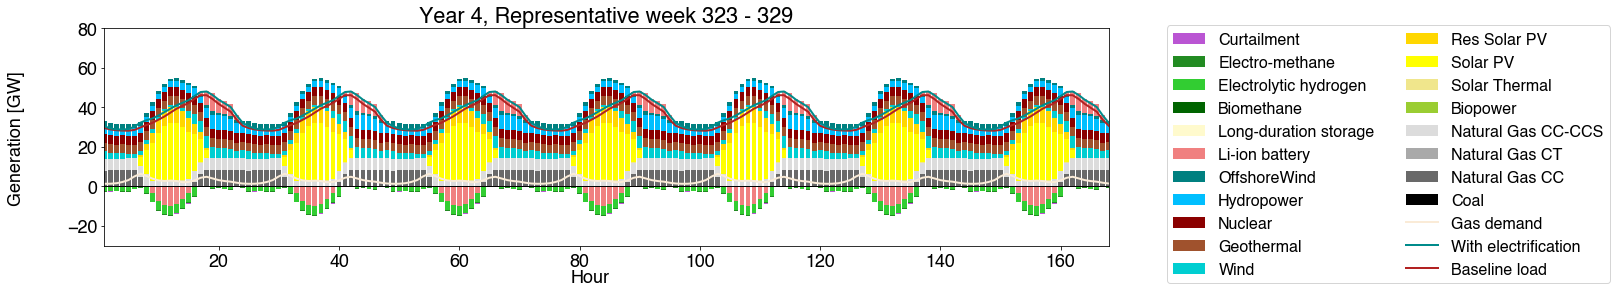

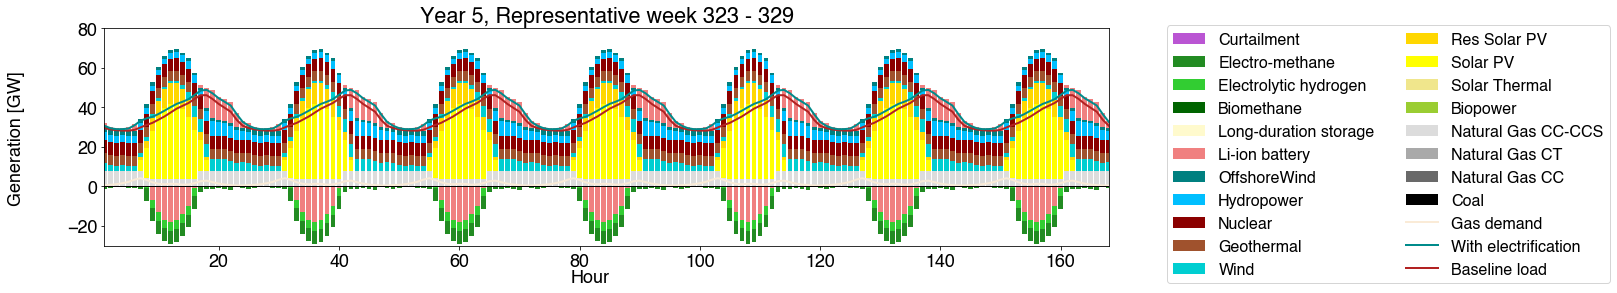

In [159]:
################################################################################################
## Hourly Dispatch
################################################################################################
resource_list_hourly = (np.append(np.append(generators["Prime Mover"].to_numpy(), storage_elec["Prime Mover"].to_numpy()), p2g["Prime Mover"].to_numpy()))
resource_list_hourly = np.where(resource_list_hourly == "Net-zero CH4", "Electro-methane",resource_list_hourly)
unique_resources_GEN = generators["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_STORAGE = storage_elec["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = p2g["Prime Mover"].drop_duplicates().to_numpy()
unique_resources_P2G = np.where(unique_resources_P2G == "Net-zero CH4", "Electro-methane",unique_resources_P2G)
unique_resources_hourly = (np.append(np.append(generators["Prime Mover"].drop_duplicates().to_numpy(), storage_elec["Prime Mover"].drop_duplicates().to_numpy()), p2g["Prime Mover"].drop_duplicates().to_numpy()))
unique_resources_hourly = np.where(unique_resources_hourly == "Net-zero CH4", "Electro-methane",unique_resources_hourly)

d = 7
nn = -5
iit = 1 # yr for comparison
appliance_cases = np.array([case1])

dataX = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityHourlyGensFullResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
data2X = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityHourlyLoadFullBaseline_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
        

all_yr = [0,1,2,3,4]

for yr in all_yr:
    fig, axes = plt.subplots(1, 1, figsize = (18,4), sharex = True, sharey = True)
    for i in range(len(appliance_cases)):
        folder = folder1
        stack = np.zeros((d*24))
        
        if i == 0:
#           cd = int(np.argmax(np.sum(data[0:10,int(yr*8760):int((yr+1)*8760)],0))/24 - 8)
            # cd = int(np.argmin(data[1,int(iit*8760):int((iit+1)*8760)])/24)  - nn
            cd = 323
            # cd = 183, 325, 360

        data = dataX[0:-1,int(yr*8760 + (cd-1)*24):int(yr*8760 + (cd-1)*24 + d*24)]/1000
        data2 = data2X[:,int(yr*8760 + (cd-1)*24):int(yr*8760 + (cd-1)*24 + d*24)]/1000

        for k in range(len(unique_resources_GEN)):
            resources = np.maximum(np.sum(data[resource_list_hourly == unique_resources_GEN[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources[0:d*24], label = unique_resources_GEN[k],color = colors_GEN[k],  bottom = stack)
            stack = stack + resources[0:d*24]
        stack_plus = stack.copy()
        stack_minus = np.zeros(np.shape(stack))
        for k in range(len(unique_resources_STORAGE)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            resources_plus = -1*np.minimum(np.sum(data[resource_list_hourly == unique_resources_STORAGE[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_plus[0:d*24], label = unique_resources_STORAGE[k],color = colors_STORAGE[k], bottom = stack_plus)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24],color = colors_STORAGE[k],  bottom = stack_minus)
            stack_plus = stack_plus.copy() + resources_plus[0:d*24]
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]

        for k in range(len(unique_resources_P2G)):
            resources_minus = -1*np.maximum(np.sum(data[resource_list_hourly == unique_resources_P2G[k]],0),0)
            axes.bar(np.linspace(1,d*24,d*24), resources_minus[0:d*24], label = unique_resources_P2G[k], color = colors_P2G[k],bottom = stack_minus)
            stack_minus = stack_minus.copy() + resources_minus[0:d*24]

        axes.bar(np.linspace(1,d*24,d*24), np.minimum((data2[0,0:d*24]-stack_minus)-stack_plus,0), color = "mediumorchid", label = "Curtailment", bottom = stack_minus)

        axes.plot(np.linspace(1,d*24,d*24), data2[2,0:d*24], label = 'Baseline load', linewidth = 2, color = "firebrick")
        axes.plot(np.linspace(1,d*24,d*24), data2[0,0:d*24], label = "With electrification", linewidth = 2, color = 'darkcyan')
        axes.plot(np.linspace(1,d*24,d*24), data2[1,0:d*24], label = 'Gas demand', linewidth = 2, color = "antiquewhite")

        axes.axhline(linewidth=1, color='k')
        axes.set_xlim([1,d*24])
        axes.set_ylim([-30,80])
        axes.set_title(f'Year {yr+1}, Representative week {cd} - {cd+6}')

    handles, labels = axes.get_legend_handles_labels()
    labels = np.where(np.array(labels) == "Electrolysis","Electrolytic hydrogen",np.array(labels))
    axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1.05), loc='upper left', prop={'size': 16},ncol=2)
    fig.text(0.5, 0.0, 'Hour', ha='center')
    fig.text(0.05, 0.5, 'Generation [GW]', va='center', rotation='vertical')
    # fig.text(0.005, 0.75, case1, ha='center', va='center', rotation='vertical')
    # fig.savefig(f"Plots/{case_study}/Hourly_Dispatch_{yr+1}_{cd}_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
    plt.show()


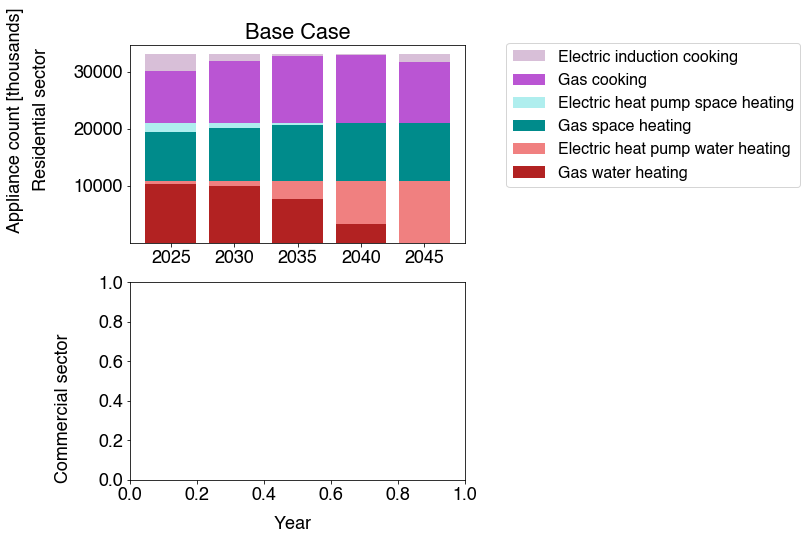

In [163]:
################################################################################################
## End-Use Appliance Decisions
################################################################################################
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_RES
unique_appliancetypes_COMM = unique_appliancetypes[6:13]
unique_appliancetypes_COMM

appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
initial_pop = appliances["Appliance Count [no.]"]/1000
NewYears = np.array([2023,2025,2030,2035,2040,2045])

appliance_labels = ["Gas water heating","Electric heat pump water heating","Gas space heating","Electric heat pump space heating","Gas cooking","Electric induction cooking"]
fig, axes = plt.subplots(2, 1, figsize = (6,8), sharex = False, sharey = False)

colors_ResApps = ["firebrick","lightcoral","darkcyan","paleturquoise","mediumorchid","thistle"]
colors_CommApps = ["thistle","mediumorchid","darkcyan","paleturquoise","firebrick","lightcoral"]

for i in range(len(appliance_cases)):
    folder = folder1
    resources = np.zeros((len(unique_appliancetypes),1))
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityApplianceResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
    newtotalpop = np.zeros((len(data[:,0]),T_inv+1))
    newtotalpop[:,0] = initial_pop
    newtotalpop[:,1:6] = totalpop
    
    stack = np.zeros((T_inv))
    for k in range(len(unique_appliancetypes_RES)):
        resources = np.sum(totalpop[appliances_list == unique_appliancetypes_RES[k],:],0)
        axes[0].bar(Years, resources,color = colors_ResApps[k],label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources
    stack = np.zeros((T_inv))
    for k in range(len(unique_appliancetypes_COMM)):
        resources = np.sum(totalpop[appliances_list == unique_appliancetypes_COMM[k],:],0)
        axes[1].bar(Years, resources,color = colors_CommApps[k],label = unique_appliancetypes_COMM[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources

        
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.05), loc='upper left', prop={'size': 16})

fig.text(-0.14, 0.75, 'Appliance count [thousands]', ha='center', va='center', rotation='vertical')
axes[0].set_title(case1)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.text(-0.08, 0.75, 'Residential sector', ha='center', va='center', rotation='vertical')
fig.text(-0.03, 0.25, 'Commercial sector', ha='center', va='center', rotation='vertical')

# fig.savefig(f"Plots/{case_study}/Appliances_Decisions_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()



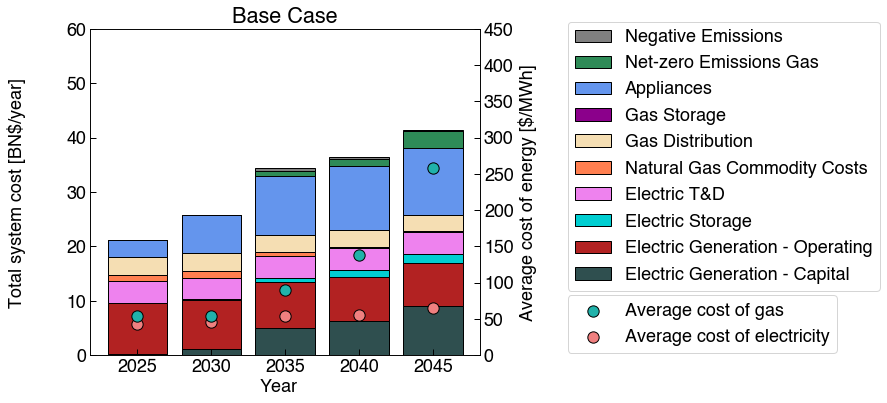

In [164]:
################################################################################################
## Total System Cost Breakdown
################################################################################################
colors_Costs = ["darkslategrey","firebrick","darkturquoise","violet","coral","wheat","darkmagenta","cornflowerblue","seagreen","grey"]
labels_Costs = ["Electric Generation - Capital","Electric Generation - Operating","Electric Storage","Electric T&D","Natural Gas Commodity Costs","Gas Distribution","Gas Storage","Appliances","Net-zero Emissions Gas","Negative Emissions"]

fig, axes = plt.subplots(1, 1, figsize = (7,6), sharex = False, sharey = False)

numm = 0
for i in range(len(appliance_cases)):
    folder = folder1
    data = np.transpose(pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityEmissionsandCostResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy())
    stack = np.zeros((T_inv))
    count = 0
    if numm == 1:
        data[1,0] = (data[1,0] + data[1,1])/2
        data[9,0] = data[9,1]
    for k in range(len(labels_Costs)):
#        if np.sum(data[count+3,:]) > 0:
        if k == 0:
            axes.bar(Years, data[count+3,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + data[count+3,:]/10**9        
            count = count+1
        if k == 1:
            axes.bar(Years, (data[count+3,:] + data[count+4,:])/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + (data[count+3,:] + data[count+4,:])/10**9                
            count = count+2
        if k > 1:
            axes.bar(Years, data[count+3,:]/10**9, label = labels_Costs[k],color = colors_Costs[k], bottom = stack, width = 4, align = "center", edgecolor= 'k')
            stack = stack + data[count+3,:]/10**9
            count = count+1
        
    axes2 = axes.twinx()
    
    # Scatter for average gas and electricity costs
    axes2.scatter(Years,data[0,:], label = "Average cost of electricity", color = "lightcoral", edgecolors= 'k', s = 128)
    axes2.scatter(Years,data[1,:], label = "Average cost of gas", color = "lightseagreen", edgecolors= 'k' , s = 128)
    # if i < 1:
    #     axes2.set_yticks([])
    # if i >= 1:
    #     axes.set_yticks([])
    axes.tick_params(direction='in', length=6, width=1, colors='k')
    axes2.tick_params(direction='in', length=6, width=1, colors='k')
    axes.axhline(linewidth=1, color='k')
    axes2.axhline(linewidth=1, color='k')

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, 1.05), loc='upper left', prop={'size': 18})
handles, labels = axes2.get_legend_handles_labels()
axes2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.2, -0.02), loc='lower left', prop={'size': 18})
axes.set_ylim([0,60])
# axes.set_ylim([0,3000000])
axes2.set_ylim([0,450])
fig.text(-0.02, 0.5, 'Total system cost [BN$/year]', ha='center', va='center', rotation='vertical')
axes.set_title(case1)
axes2.set_ylabel("Average cost of energy [$/MWh]")
fig.text(0.5, 0.04, 'Year', ha='center')
# fig.savefig(f"Plots/{case_study}/Total_Costs_{date_stamp1}.png",bbox_inches = "tight", dpi = 300)
plt.show()

<ipython-input-166-0c7bd43b8b4f>:37: RuntimeWarning: invalid value encountered in true_divide
  cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]


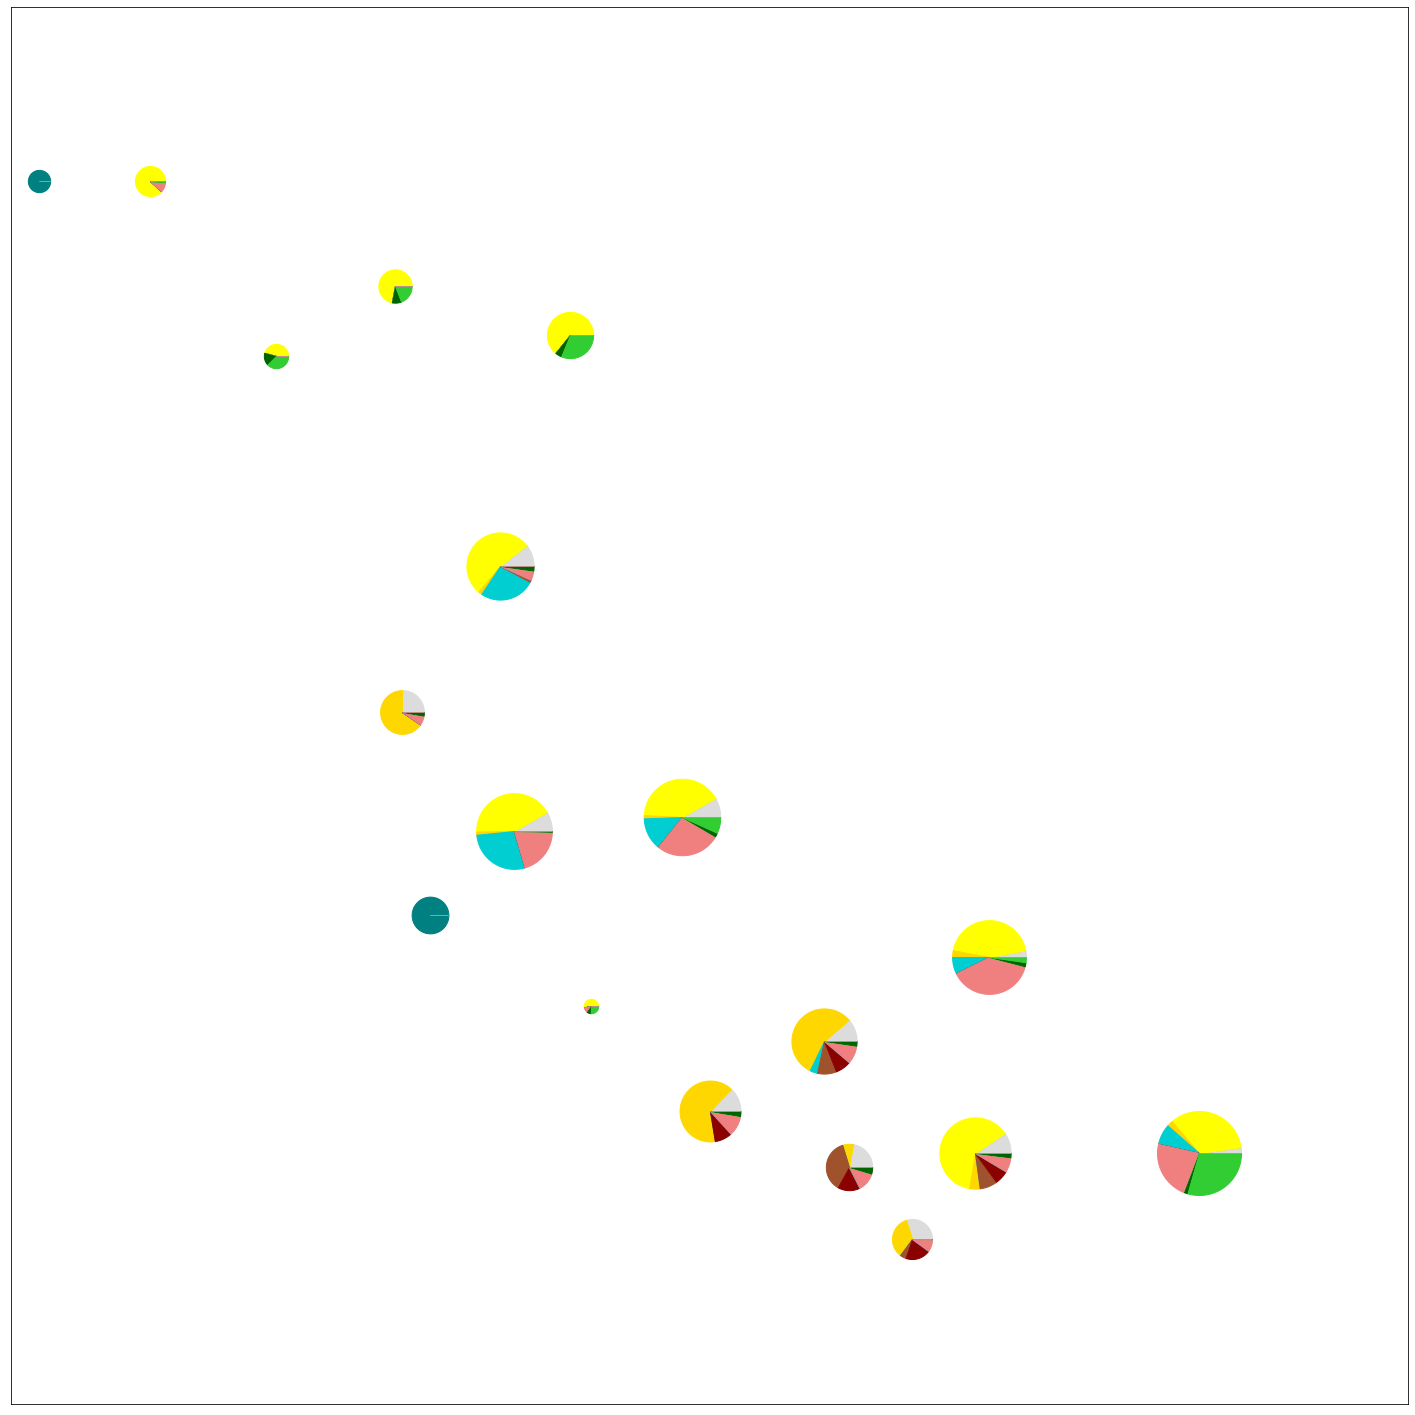

In [166]:
################################################################################################
## Locational Capacity Build Decisions
################################################################################################
result_yr = 4

fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
xx = 0

nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1,   1.9, 2.8,  3.6,  4.15, 5 ,  6.45,  6.0,  5.82, 6.9, 2.75, 3.5, 4.8,  7, 8.5,   4, 0,0,9,0,0.2, 3])
nodal_locs[:,1] = np.array([8.75,7.5, 4.95, 4.1,  2.85, 2.1, 1.18,  1.7, 2.6, 1.8, 8,    6,   4.2, 3.2,1.8, 7.65,0,0,4,0,8.75,3.5])

for ii in range(len(appliance_cases)):
    data_plot = np.zeros((np.max(locational_resources),len(unique_resources)))
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityCapacityBuildResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    data = data[0:-1,:]
    data_retired = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityCapacityRetiredResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    data_retired = data_retired[0:-1,:]
    stack = np.zeros((T_inv))
    stack_minus = stack.copy()
    for kk in range(np.max(locational_resources)):
        resources = np.zeros((len(unique_resources),T_inv))
        resources_minus = np.zeros((len(unique_resources),T_inv))
        for k in range(len(unique_resources)):
            for j in range(T_inv):
                for jj in range(j+1):
                    resources_minus[k,j] = resources_minus[k,j]+np.sum(data_retired[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)
                    resources[k,j] = resources[k,j]+np.sum(data[(resource_list == unique_resources[k]) & (locational_resources == kk+1),jj],0)

            data_plot[kk,k] = resources[k,result_yr-1]
            
    sizes = 550*np.random.rand(np.max(locational_resources)) + 250
    sizes = np.sum(data_plot,1)*0.8
    for i in range(len(data_plot[:,0])):
        r = np.zeros((len(data_plot[0,:])+1))
        loc = nodal_locs[i,:]
        cum_data = np.cumsum(data_plot[i,:])/ np.cumsum(data_plot[i,:])[-1]
        cum_data[np.isnan(cum_data)] = 0
        for j in range(len(data_plot[0,:])):
            r[j+1] = cum_data[j]
            x = np.cos(2 * np.pi * np.linspace(r[j], r[j+1]))
            y = np.sin(2 * np.pi * np.linspace(r[j], r[j+1]))
            xy = np.row_stack([[0, 0], np.column_stack([x, y])])
            s1 = np.abs(xy).max()
            axes.scatter(loc[0], loc[1], marker=xy, s=s1**2 * sizes[i], facecolor = colors[j])
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlim([0,10])
    axes.set_ylim([0,10])
    # axes.patch.set_facecolor('white')
    axes.patch.set_alpha(0.7)
# fig.savefig(f"Plots/{case_study}/Locational_Plot_{result_yr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.tight_layout()


In [22]:
def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

[ 1.35454207e+03  4.70841400e+02  5.16359697e-01  6.90591497e+01
 -4.61053430e+01 -6.64515935e+02  0.00000000e+00  9.69249014e+02
  2.84589418e+02  3.65976394e+02 -8.87676507e+01 -6.65540947e+02
 -1.11985736e+03  2.11233538e+02  1.35525937e+03  6.53825374e+02
 -5.21008760e+02  9.02950647e+02 -7.74917908e+02  1.44136360e+03
 -2.59763889e+02 -2.37515064e+02 -2.22561356e+03 -8.10413513e+02
  1.93140359e+03 -1.38969954e+03 -1.53047265e+03  0.00000000e+00
 -7.44724817e+02  7.45121693e+02 -9.24889736e+02  9.57855326e+02
  3.85466556e+02]


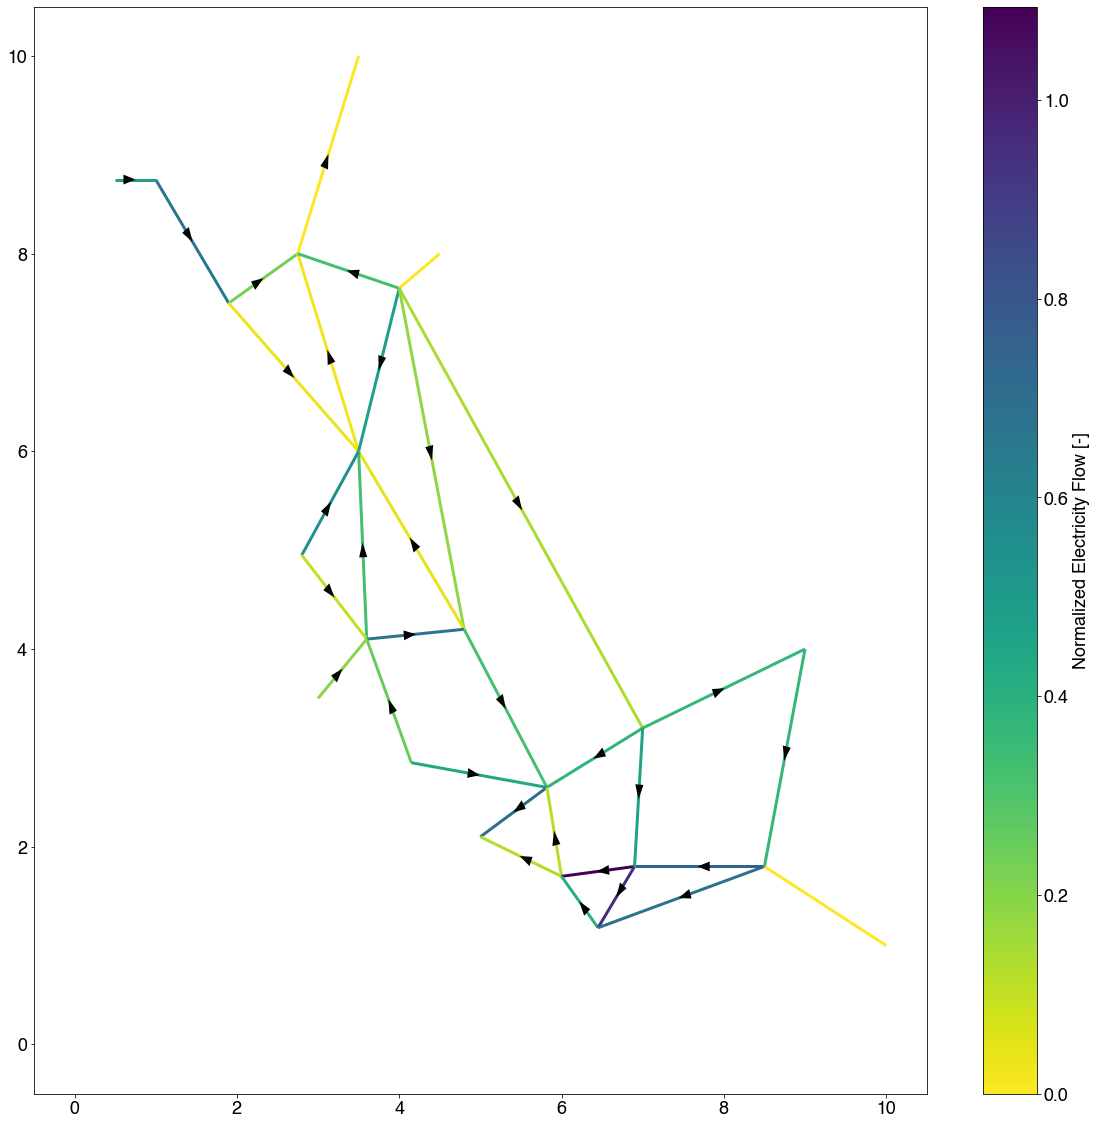

In [58]:
################################################################################################
## Flow gas and electricity
################################################################################################
from numpy import linalg as LA
fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
nodal_locs = np.random.rand(np.max(locational_resources),2)
nodal_locs[:,0] = np.array([1,   1.9, 2.8,  3.6,  4.15, 5 ,  6.45,  6.0,  5.82, 6.9, 2.75, 3.5, 4.8,  7, 8.5,   4,3.5,4.5,9,10,0.5,3])  # x
nodal_locs[:,1] = np.array([8.75,7.5, 4.95, 4.1,  2.85, 2.1, 1.18,  1.7, 2.6, 1.8, 8,    6,   4.2, 3.2,1.8, 7.65,10,8,4,1,8.75,3.5])  # y

# data_gas (row = edge, col = days for yrs 1-5)
# data_elec (row = edge, col = hours in day, days for yrs 1-5)
data_gas = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityDailyGasTransmissionFullResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
data_elec = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityHourlyTransmissionFullResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
elec_network = pd.read_csv("Data/ElecTransmissionNetwork.csv")
nodein_elec = elec_network["Node In"]
nodeout_elec = elec_network["Node Out"]
gas_network = pd.read_csv("Data/GasTransmissionNetwork.csv")
nodein_gas = gas_network["Node In"]
nodeout_gas = gas_network["Node Out"]

yr = 4
cd = 180
d = 1 # no changing this!
hr = 12
max_gas = np.max(data_gas)
max_elec = np.max(data_elec)
day_gas = data_gas[:,int(yr*365 + (cd-1)):int(yr*365 + (cd-1) + d)]
day_elec = data_elec[:,int(yr*8760 + (cd-1)*24):int(yr*8760 + (cd-1)*24 + d*24)]
print(day_elec[:,hr])

elec_flow = np.linspace(1., 4., len(nodein_elec)+1)
linex = np.eye(len(nodein_elec)+1, 100)
liney = np.eye(len(nodein_elec)+1, 100)

for i in range(len(nodein_elec)):
    nodeoutx = nodal_locs[nodeout_elec[i]-1,0]
    nodeouty = nodal_locs[nodeout_elec[i]-1,1]
    nodeinx = nodal_locs[nodein_elec[i]-1,0]
    nodeiny = nodal_locs[nodein_elec[i]-1,1]
    linex[i,:] = np.linspace(nodeoutx,nodeinx,100)
    liney[i,:] = np.linspace(nodeouty,nodeiny,100)

    elec_flow[i] = abs(day_elec[i,hr])/max_elec
    
linex[len(nodein_elec),:] = np.linspace(0,0,1)
liney[len(nodein_elec),:] = np.linspace(0,0,1)
elec_flow[len(nodein_elec)] = 1

lc = multiline(linex, liney, elec_flow, cmap='viridis_r', lw=3)
for i in range(len(nodein_elec)):
    plt.arrow(linex[i,50], liney[i,50], np.sign(day_elec[i,hr])*(linex[i,50]-linex[i,51]), np.sign(day_elec[i,hr])*(liney[i,50]-liney[i,51]), shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
axcb = fig.colorbar(lc)
axcb.set_label('Normalized Electricity Flow [-]')
fig.savefig(f"Plots/{case_study}/Flow_Elec_{yr+1}_{cd}_{hr}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
plt.show()

# fig, axes = plt.subplots(1, 1, figsize = (20,20), sharex = True, sharey = True)
# gas_flow = np.linspace(1., 4., len(nodein_gas)-2+1)
# linexgas = np.eye(len(nodein_gas)-2+1, 100)
# lineygas = np.eye(len(nodein_gas)-2+1, 100)

# for i in range(len(nodein_gas)-2):
#     nodeoutxgas = nodal_locs[nodeout_gas[i]-1,0]
#     nodeoutygas = nodal_locs[nodeout_gas[i]-1,1]
#     nodeinxgas = nodal_locs[nodein_gas[i]-1,0]
#     nodeinygas = nodal_locs[nodein_gas[i]-1,1]
#     linexgas[i,:] = np.linspace(nodeoutxgas,nodeinxgas,100)
#     lineygas[i,:] = np.linspace(nodeoutygas,nodeinygas,100)

#     gas_flow[i] = abs(day_gas[i])/max_gas
# linex[len(nodein_gas),:] = np.linspace(0,0,1)
# liney[len(nodein_gas),:] = np.linspace(0,0,1)
# gas_flow[len(nodein_gas)-2] = 1

# lc = multiline(linexgas, lineygas, gas_flow, cmap='magma_r', lw=3)
# for i in range(len(nodein_gas)-2):
#     plt.arrow(linexgas[i,50], lineygas[i,50], linexgas[i,50]-linexgas[i,51], lineygas[i,50]-lineygas[i,51], shape='full', lw=0, length_includes_head=True, head_width=.1,color = "black",zorder=10)
# axcb = fig.colorbar(lc)
# axcb.set_label('Normalized Gas Flow [-]')
# fig.savefig(f"Plots/{case_study}/Flow_Gas_{yr+1}_{cd}_{date_stamp1}.png", transparent=True,bbox_inches = "tight", dpi = 300)
# plt.show()



In [ ]:
################################################################################################
## Electricity and gas allocation by sector
################################################################################################
appliances = pd.read_csv("Data/EndUseAppliancesNetwork.csv")
appliances_gascons = pd.read_csv("Data/ApplianceProfiles_GASNetworkCold.csv")
appliances_eleccons = pd.read_csv("Data/ApplianceProfiles_ELECNetworkCold.csv")
unique_appliancetypes =  appliances["Appliance Name"].drop_duplicates().to_numpy()
unique_appliancetypes_RES = unique_appliancetypes[0:6]
unique_appliancetypes_RES
unique_appliancetypes_COMM = unique_appliancetypes[6:13]
unique_appliancetypes_COMM

appliance_labels = ["Gas water heating","Electric heat pump water heating","Electric heat pump space heating","Gas space heating","Gas cooking","Electric induction cooking"]
colors_Apps = ["red","black","blue","green","yellow","purple","orange","black","red","blue","green","yellow","purple","orange"]
colors_ResApps = ["firebrick","lightcoral","paleturquoise","darkcyan","mediumorchid","thistle"]
colors_CommApps = ["thistle","mediumorchid","darkcyan","paleturquoise","firebrick","lightcoral"]

xy = 0
fig, axes = plt.subplots(2, 2, figsize = (12,12), sharex = False, sharey = False)
appliance_cases = np.array([case1,case2])
axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1])#,axes[0,2])#,axes[0,3])
axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1])#,axes[1,2])#,axes[1,3])

for i in range(len(appliance_cases)):
    if i == 0: ## will also need to change folder parameters such as system, region if case arises
        folder = folder1
    else:
        folder = folder2

    ## Total annual electricity generation
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityApplianceResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    baseline_demands = pd.read_csv("Output/Local/GenerationSave.csv").to_numpy()
    appliance_profile_elec = pd.read_csv("Output/Local/AppliancesProfileSave_ELEC.csv").to_numpy()
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    appliances_demand_elec = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
        appliances_demand_elec[:,k] = totalpop[:,k]*1000* np.transpose(appliance_profile_elec[:,1])

    stack = np.zeros((T_inv))
    resources = baseline_demands[1,:].copy()/10**6
    axes[0,i].bar(Years, resources, label = "Baseline electricity demand", color = "gray", alpha = 1, edgecolor = 'black', linewidth = 2, bottom = stack, width = 4, align = "center")
    stack = stack + resources
    for k in range(len(unique_appliancetypes_RES)):
        resources = np.sum(appliances_demand_elec[appliances_list == unique_appliancetypes_RES[k],:],0)/10**6
        axes[0,i].bar(Years, resources,color = colors_ResApps[k], label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources

    for k in range(len(unique_appliancetypes_COMM)):
        resources = np.sum(appliances_demand_elec[appliances_list == unique_appliancetypes_COMM[k],:],0)/10**6
        axes[0,i].bar(Years, resources,color = colors_CommApps[k], label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources
    

    
    ## Total annual gas generation
    data = pd.read_csv(f"%s/{system}{region}{num}{biomethane}biomethane{industrials}industrials{buildingretrofits}buildingretrofits{GasQuality}GasQualityApplianceResults_{case}{offsets_case}{retirements_case}{CleanElecCosts}CostElec{CleanGasCosts}CostGas{NETSCost}NETsCost.csv" % folder).to_numpy()
    baseline_demands = pd.read_csv("Output/Local/GenerationSave.csv").to_numpy()
    appliance_profile_gas = pd.read_csv("Output/Local/AppliancesProfileSave_GAS.csv").to_numpy()
    
    newbuild = np.zeros((len(data[:,0]),T_inv))
    premature = np.zeros((len(data[:,0]),T_inv))
    totalpop = np.zeros((len(data[:,0]),T_inv))
    appliances_demand = np.zeros((len(data[:,0]),T_inv))
    for k in range(T_inv):
        newbuild[:,k] = data[:,k*3]
        premature[:,k] = data[:,k*3+1]
        totalpop[:,k] = data[:,k*3+2]
        appliances_demand[:,k] = totalpop[:,k]*1000* np.transpose(appliance_profile_gas[:,1])
    
    stack = np.zeros((T_inv))
    resources = baseline_demands[0,:].copy()/10**6
    axes[1,i].bar(Years, resources, label = "Baseline gas demand", color = "gray", alpha = 1, edgecolor = 'black', linewidth = 2, bottom = stack, width = 4, align = "center")
    stack = stack + resources
    for k in range(len(unique_appliancetypes_RES)):
        resources = np.sum(appliances_demand[appliances_list == unique_appliancetypes_RES[k],:],0)/10**6
        axes[1,i].bar(Years, resources,color = colors_ResApps[k], label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources
    
    for k in range(len(unique_appliancetypes_COMM)):
        resources = np.sum(appliances_demand[appliances_list == unique_appliancetypes_COMM[k],:],0)/10**6
        axes[1,i].bar(Years, resources,color = colors_CommApps[k], label = appliance_labels[k], bottom = stack, width = 4, align = "center")
        stack = stack + resources
    
    for ii in range(2):
        axes[ii,i].axhline(linewidth=1, color='k')
        axes[ii,i].tick_params(direction='in', length=6, width=1, colors='k')


handles, labels = axes[0,1].get_legend_handles_labels()
axes[0,1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.2), loc='upper left', prop={'size': 16})
handles, labels = axes[1,1].get_legend_handles_labels()
axes[1,1].legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.1, 1.2), loc='upper left', prop={'size': 16})

fig.text(0.06, 0.75, 'Annual electricity \n gen. [TWh/yr]', ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.33, 'Annual gas \n gen. [TWh/yr]', ha='center', va='center', rotation='vertical')

axes[0,0].set_ylim([-2,25])
axes[0,1].set_ylim([-2,25])
axes[1,0].set_ylim([-2,25])
axes[1,1].set_ylim([-2,25])
axes[0,0].set_title(case1)
axes[0,1].set_title(case2)
fig.text(0.5, 0.04, 'Year', ha='center')
fig.suptitle(f"Appliance optimization scenarios")
# fig.savefig(f"Plots/Investment_Period_{date_stamp1}_{date_stamp2}.png")
plt.show()
